**Глава 3. Преобразования изображений**

Навигация к соседним тетрадям:
<!--NAVIGATION-->
<[Глава 2. Локальные дескрипторы изображений](2_local_image_descriptors.ipynb) | [Содержание](0_index.ipynb) | [Глава 4. Модели камер и дополненная реальность](4_camera_models_and_augmented_reality.ipynb)>

<a href="https://colab.research.google.com/github/mualal/computer-vision-with-python/blob/master/3_image_to_image_mapping.ipynb">    <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Открыть и запустить в Google Colaboratory"></a>

In [1]:
from PIL import Image
import os
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

In [2]:
try:
    import google.colab, sys
    !git clone https://github.com/mualal/computer-vision-with-python.git
    sys.path.append('computer-vision-with-python')
    %cd computer-vision-with-python
except:
    import sys
    sys.path.append('..')

In [3]:
import imtools, homography, warp, imregistration, pca,  sift

# Гомографии

**Гомография** - проективное преобразование одной плоскости в другую.

Практические применения гомографии: регистрация изображений, ректификация изображений, деформирование текстур, создание панорам.

$$\begin{pmatrix} x' \\ y' \\ w'\end{pmatrix}
=
\begin{pmatrix} h_1 & h_2 & h_3 \\ h_4 & h_5 & h_6 \\ h_7 & h_8 & h_9 \end{pmatrix}
\begin{pmatrix} x \\ y \\ w\end{pmatrix}
\Leftrightarrow
\textbf{x'}=\textbf{H}\textbf{x}$$

В однородных координатах точка определена с точностью до масштабного коэффициента, т.е. координаты

$$\textbf{x}=(x,y,w)=(\alpha x, \alpha y, \alpha w)=(x/w, y/w, 1)$$

определяют одну и ту же точку **на плоскости**.

Часто производится нормировка: полагают $w=1$ и получают однозначное представление точки изображения с координатами $(x,y)$. Дополнительная координата $w$ упрощает представление гомографии $\textbf{H}$ одной матрицей.

Частные случаи гомографий:

- аффинное преобразование (сохраняет условие $w=1$, но не позволяет описать сильные деформации) -- распадается на обратимую матрицу $\textbf{A}$ и вектор параллельного переноса $\textbf{t}$:

$$\begin{pmatrix} x' \\ y' \\ 1\end{pmatrix}
=
\begin{pmatrix} a_1 & a_2 & t_x \\ a_3 & a_4 & t_y \\ 0 & 0 & 1 \end{pmatrix}
\begin{pmatrix} x \\ y \\ 1\end{pmatrix}
\Leftrightarrow
\textbf{x'}=\begin{pmatrix} \textbf{A} & \textbf{t} \\ 0 & 1 \end{pmatrix} \textbf{x}
$$

- преобразование подобия (включают изометрические преобразования и операции масштабирования)

$$\begin{pmatrix} x' \\ y' \\ 1\end{pmatrix}
=
\begin{pmatrix} s\cos{\theta} & -s\sin{\theta} & t_x \\ s\sin{\theta} & s\cos{\theta} & t_y \\ 0 & 0 & 1 \end{pmatrix}
\begin{pmatrix} x \\ y \\ 1\end{pmatrix}
\Leftrightarrow
\textbf{x'}=\begin{pmatrix} s\textbf{R} & \textbf{t} \\ 0 & 1 \end{pmatrix} \textbf{x}
$$

Аффинные преобразования используются для деформирования (при сильных деформациях полезно использовать триангуляцию).

Преобразования подобия используются для регистрации изображений.

Гомографии (проективные преобразования) общего вида используются для создания панорам.


# Деформирование изображений

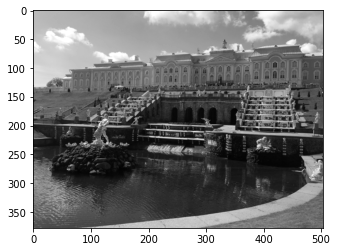

In [4]:
# открыть изображение, преобразовать в numpy-массив, изменить размер, преобразовать в чёрно-белое изображение
im = np.array(Image.open(os.path.join('images_input', 'Peterhof.jpg')).resize((504, 378)).convert('L'))
# настройка показа в чёрно-белых тонах
plt.gray()
# показ изображения
plt.imshow(im)

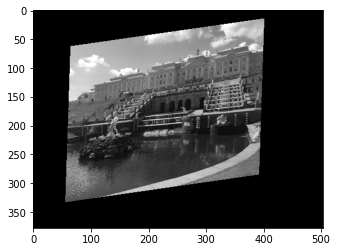

In [5]:
# задать матрицу аффинной гомографии
h = np.array([[1.4, 0.2, -100], [0.05, 1.5, -100], [0, 0, 1]])
# применить аффинное преобразование к изображению
im2 = ndimage.affine_transform(im, h[:2, :2], (h[0, 2], h[1, 2]))
# показ изображения
plt.imshow(im2)

## Изображение внутри изображения

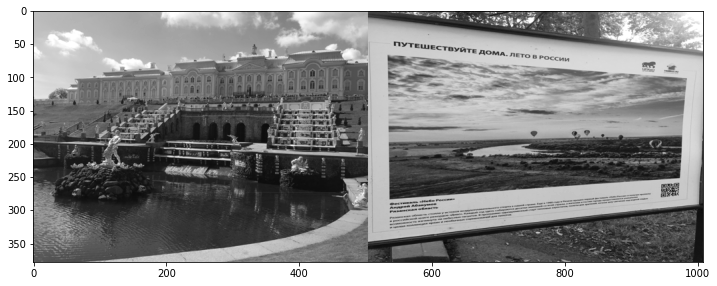

In [6]:
# открыть первое изображение, преобразовать в numpy-массив, изменить размер, преобразовать в чёрно-белое изображение
im1 = np.array(Image.open(os.path.join('images_input', 'Peterhof.jpg')).resize((504, 378)).convert('L'))
# открыть второе изображение, преобразовать в numpy-массив, изменить размер, преобразовать в чёрно-белое изображение
im2 = np.fliplr(np.array(Image.open(os.path.join('images_input', 'Sky.jpg')).resize((378, 504)).convert('L')).T)
# настройка показа изображения
plt.figure(figsize=(12,12))
plt.imshow(np.concatenate((im1, im2), axis=1))

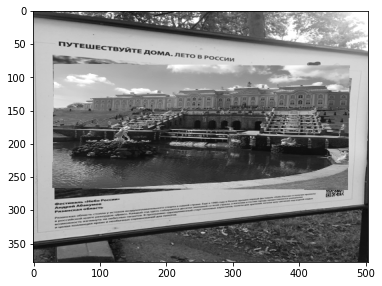

In [7]:
# %matplotlib widget

# задать координаты целевых точек (для углов первого изображения) на втором изображении
# (перечисляются против часовой стрелки, начиная с левого верхнего, - точки хранятся в массиве по столбцам)
tp = np.array([[65, 282.8, 253, 99.6], [27.5, 32, 470.6, 480.7], [1, 1, 1, 1]])
# переместить первое изображение во второе с помощью аффинного преобразования так,
# чтобы углы были как можно ближе к tp
im3 = warp.image_to_image(im1, im2, tp)
# настройка показа изображения
plt.figure(figsize=(6, 6))
plt.imshow(im3)

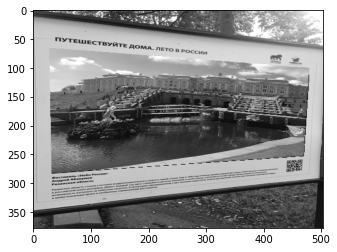

In [8]:
m, n = im1.shape[:2]
fp = np.array([[0, m, m, 0], [0, 0, n, n], [1, 1, 1, 1]])

# первый треугольник
tp2 = tp[:, :3]
fp2 = fp[:, :3]
# вычислить аффинную гомографию для первого треугольника
h = homography.haffine_from_points(tp2, fp2)
# применить аффинное преобразование к первому треугольнику
im1_t = ndimage.affine_transform(im1, h[:2, :2], (h[0, 2], h[1, 2]), im2.shape[:2])
# альфа-отображение для первого треугольника
alpha = warp.alpha_for_triangle(tp2, im2.shape[0], im2.shape[1])
im3 = (1 - alpha) * im2 + alpha * im1_t

# второй треугольник
tp2 = tp[:, [0, 2, 3]]
fp2 = fp[:, [0, 2, 3]]
# вычислить аффинную гомографию для второго треугольника
h = homography.haffine_from_points(tp2, fp2)
# применить аффинное преобразование ко второму треугольнику
im1_t = ndimage.affine_transform(im1, h[:2, :2], (h[0, 2], h[1, 2]), im2.shape[:2])
# альфа-отображение для второго треугольника
alpha = warp.alpha_for_triangle(tp2, im2.shape[0], im2.shape[1])
im4 = (1 - alpha) * im3 + alpha * im1_t

# настройка показа изображения
plt.figure()
plt.imshow(im4)
plt.show()

## Кусочно-аффинное деформирование

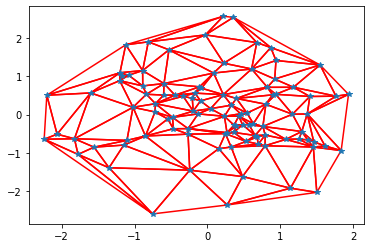

In [9]:
# генерируем 2 массива со случайными числами
x, y = np.array(np.random.standard_normal((2, 100)))
# проводим триангуляцию Делоне (получаем массив, каждая сторока которого
# представляет собой индексы в массивах x и y трёх вершин каждого треугольника)
tri = Delaunay(np.c_[x, y]).simplices

# строим фигуру
plt.figure()
# для каждого треугольника
for t in tri:
    # получаем список индексов его вершин
    t_ext = [t[0], t[1], t[2], t[0]]
    # строим отрезки, соединяющие вершины треугольника
    plt.plot(x[t_ext], y[t_ext], 'r')
# отмечаем звёздочками точки, по которым была проведена триангуляция
plt.plot(x, y, '*')
# показываем построенную картину :)
plt.show()

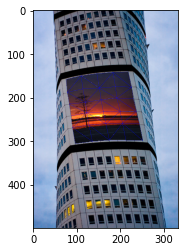

In [10]:
# открыть деформируемое изображение, преобразовать в numpy-массив
fromim = np.array(Image.open(os.path.join('images_input', 'sunset_tree.jpg')))
# создать узлы для триангуляции
y, x = np.meshgrid(range(5), range(6))
x = (fromim.shape[0] / 5) * x.flatten()
y = (fromim.shape[1] / 4) * y.flatten()

# триангулировать
tri = warp.triangulate_points(x, y)

# открыть конечное изображение и файл с координатами конечных точек
im = np.array(Image.open(os.path.join('images_input', 'turningtorso1.jpg')))
tp = np.loadtxt(os.path.join('images_input', 'turningtorso1_points.txt'))

# преобразовать точки из декартовых координат к однородным
fp = np.vstack((x, y, np.ones((1, len(x)))))
tp = np.vstack((tp[:, 1], tp[:, 0], np.ones((1, len(tp)))))

# деформировать треугольники
im = warp.pw_affine(
    from_im=fromim,
    to_im=im,
    from_points=fp,
    to_points=tp,
    tri=tri
)
# настройка показа изображения
plt.figure()
plt.imshow(im)
warp.plot_mesh(tp[1], tp[0], tri)
plt.show()

## Регистрация изображений

**Регистрацией изображения** называется процесс приведения его к единой системе координат.

In [11]:
xml_filename = os.path.join('images_input', 'jkfaces.xml')
points = imregistration.read_points_from_xml(xml_filename)
imregistration.rigit_alignment(points, os.path.join('images_input', 'jkfaces'))

c:\Users\almuravtsev\Documents\computer-vision-with-python\pca.py:26: RuntimeWarning: invalid value encountered in sqrt
  values = np.sqrt(eigenvalues)[::-1]  # меняем порядок (так как исходно в порядке возрастания важности)


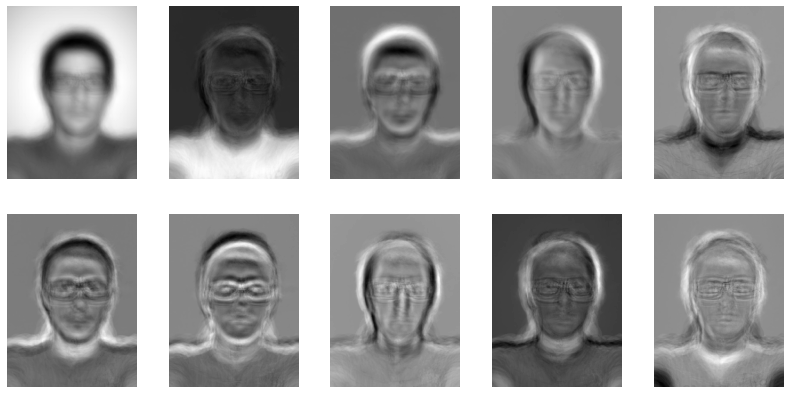

In [12]:
imlist = imtools.get_imlist(os.path.join('images_input', 'jkfaces'))

im_example = np.array(Image.open(imlist[0]))
m, n = im_example.shape[0:2]
immatrix = np.array([np.array(Image.open(im).convert('L')).flatten() for im in imlist[:160]], 'f')
v, s, immean = pca.pca(immatrix)

plt.figure(figsize=(14,7))
plt.gray()
plt.subplot(2, 5, 1)
plt.axis('off')
plt.imshow(immean.reshape((m, n)))
for i in range(9):
    plt.subplot(2, 5, i+2)
    plt.axis('off')
    plt.imshow(v[i].reshape((m, n)))


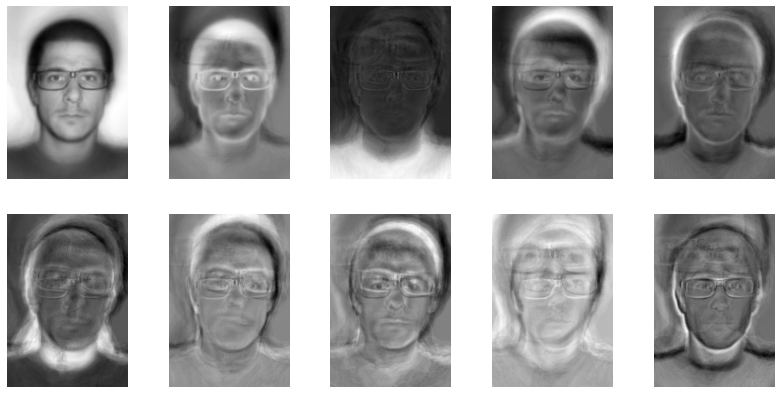

In [13]:
imlist = imtools.get_imlist(os.path.join('images_input', 'jkfaces', 'aligned'))

im_example = np.array(Image.open(imlist[0]))
m, n = im_example.shape[0:2]
immatrix = np.array([np.array(Image.open(im).convert('L')).flatten() for im in imlist[:160]], 'f')
v, s, immean = pca.pca(immatrix)

plt.figure(figsize=(14,7))
plt.gray()
plt.subplot(2, 5, 1)
plt.axis('off')
plt.imshow(immean.reshape((m, n)))
for i in range(9):
    plt.subplot(2, 5, i+2)
    plt.axis('off')
    plt.imshow(v[i].reshape((m, n)))

# Создание панорам

Панорамы создаются на основе двух (или более) изображений, снятых в одном и том же месте. Для создания панорамы используется гомографическая связанность этих изображений.

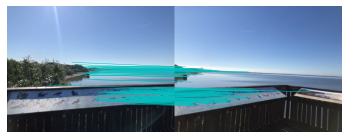

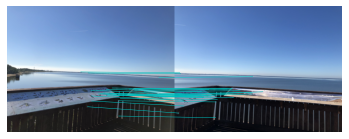

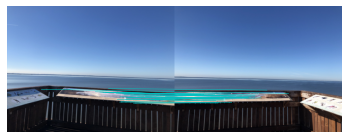

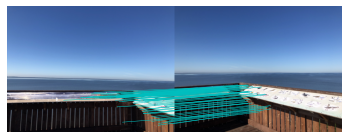

In [14]:
# найти соответственные точки на изображениях, снятых в одном и том же месте (поиск с помощью SIFT-признаков)
images = [np.array(Image.open(os.path.join('images_input', f'Kotlin_pan{num}.jpg')).resize((504, 378))) for num in range(1, 6)]

sift_points = [None] * len(images)
descriptors = [None] * len(images)
matches = [None] * len(images)

for i in range(5):
    sift_points[i], descriptors[i] = sift.find_sift_points_and_descriptors(images[i])

for i in range(4):
    matches[i] = sift.match(descriptors[i], descriptors[i+1])
    sift.plot_matches(
        images[i],
        images[i+1],
        [(p.pt[1], p.pt[0]) for p in sift_points[i]],
        [(p.pt[1], p.pt[0]) for p in sift_points[i + 1]],
        matches[i],
        show_below=False
    )
sift_points_features = [np.array([[p.pt[1], p.pt[0], p.size, p.angle] for p in pts]) for pts in sift_points]

## RANSAC. Устойчивое вычисление гомографии

**RANSAC (RANdom SAmple Consensus)** - итеративный метод подгонки моделей к данным, содержащим выбросы.

Идея в том, что данные могут содержать регулярные точки, описываемые моделью, и выбросы - точки, не укладывающиеся в модель.

Стандартный пример - аппроксимация прямой множества точек, содержащего выбросы. Простой метод наименьших квадратов в данном случае не годится, но RANSAC при некоторой удаче может выделить регулярные точки и построить правильную аппроксимацию.

In [15]:
def convert_points(
    j: int
):
    ndx1 = matches[j].nonzero()[0]
    from_points = homography.make_homog(sift_points_features[j][ndx1, :2].T)
    ndx2 = [int(matches[j][i]) for i in ndx1]
    to_points = homography.make_homog(sift_points_features[j+1][ndx2, :2].T)
    return from_points, to_points

model = homography.RansacModel()

from_points, to_points = convert_points(1)
h_12 = homography.h_from_ransac(
    from_points,
    to_points,
    model
)[0]

from_points, to_points = convert_points(0)
h_01 = homography.h_from_ransac(
    from_points,
    to_points,
    model
)[0]

to_points, from_points = convert_points(2)
h_32 = homography.h_from_ransac(
    from_points,
    to_points,
    model
)[0]

to_points, from_points = convert_points(3)
h_43 = homography.h_from_ransac(
    from_points,
    to_points,
    model
)[0]


## Сшивка изображений

In [16]:
delta = 2000
im_12 = warp.panorama(h_12, images[1], images[2], delta, delta)
im_02 = warp.panorama(np.dot(h_12, h_01), images[1], im_12, delta, delta)
im_32 = warp.panorama(h_32, images[1], im_02, delta, delta)
im_42 = warp.panorama(np.dot(h_32, h_43), images[1], im_32, delta, 2*delta)

warp-right
warp-right
warp-left
warp-left


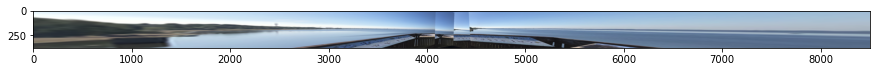

In [17]:
plt.figure(figsize=(15,20))
plt.imshow(np.uint8(im_42))

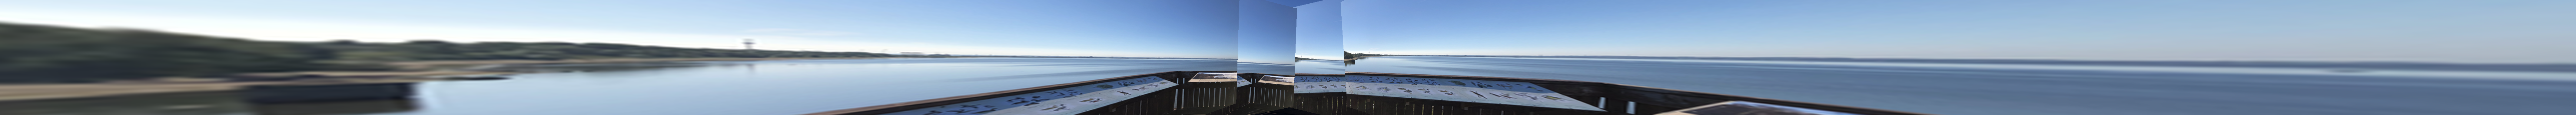

In [18]:
Image.fromarray(np.uint8(im_42))

<!--NAVIGATION-->
<[Глава 2. Локальные дескрипторы изображений](2_local_image_descriptors.ipynb) | [Содержание](0_index.ipynb) | [Глава 4. Модели камер и дополненная реальность](4_camera_models_and_augmented_reality.ipynb)>

<a href="https://colab.research.google.com/github/mualal/computer-vision-with-python/blob/master/3_image_to_image_mapping.ipynb">    <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Открыть и запустить в Google Colaboratory"></a>